<a href="https://colab.research.google.com/github/Kirk-KD/caries-segmentation/blob/master/caries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

from google.colab import drive
drive.mount('/content/drive', force_remount=False)

import detectron2
from detectron2 import model_zoo
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_train_loader, DatasetMapper
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
import matplotlib.pyplot as plt
from collections import Counter
import torch
import os
import random
import numpy as np
from PIL import Image
from detectron2.utils.visualizer import Visualizer
from torch.utils.data import WeightedRandomSampler
import json
import cv2

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-7xjrhz5f
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-7xjrhz5f
  Resolved https://github.com/facebookresearch/detectron2.git to commit a1ce2f956a1d2212ad672e3c47d53405c2fe4312
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 59.1 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp312-cp312-linux_x86_64.whl size=6733300 sha256=60f384ec5ac25a552cfbecaf4aedfec942c149438673ce64ccf096e00ed56e89
  Stored in directory: /tmp/pip-ephem-wheel-cache-lrujvu0e/wheels/d3/6e/bd/1969578f1456a6be

In [ ]:
dataset_root = "/content/drive/MyDrive/Colab Notebooks/Dental Caries Lesion Stages/caries-dataset"
class_names = ["caries-enamel", "caries-dentin", "caries-pulp"]
splits = ["train", "test", "valid"]

# Clean data

The original data contained some unused and garbled class names, which have already been removed manually. The following cell addresses the misalignment of the remaining class ID mapping.

Originally, the mapping was:
- 3 = dentin
- 4 = enamel
- 5 = pulp

For the sake of clarity, we will use the following code to generate `_annotations_clean.coco.json` in each of `train`, `valid`, and `test`, from `_annotations.coco.json`, with the new mapping:
- 1 = enamel
- 2 = dentin
- 3 = pulp

The new mapping will respect detectron2's expected ID range of `[1, #categories]`, and reflect the layers of tooth from the outside in.

This also means the annotation classes must be changed for each image too, with the following change map:
- 3 -> 2
- 4 -> 1
- 5 -> 3

In [ ]:
change_map = {
    3: 2,
    4: 1,
    5: 3
}

for folder in splits:
    with open(f"{dataset_root}/{folder}/_annotations.coco.json", "r") as f:
        data = json.load(f)

    data["categories"] = [
        {
            "id": 1,
            "name": "caries-enamel",
            "supercategory": "caries-z1wh"
        },
        {
            "id": 2,
            "name": "caries-dentin",
            "supercategory": "caries-z1wh"
        },
        {
            "id": 3,
            "name": "caries-pulp",
            "supercategory": "caries-z1wh"
        }
    ]

    for ann in data["annotations"]:
        ann["category_id"] = change_map[ann["category_id"]]

    with open(f"{dataset_root}/{folder}/_annotations_clean.coco.json", "w") as f:
        json.dump(data, f)

After data is cleaned and remapped, we can now load from `_annotations_clean.coco.json` of each folder.

In [ ]:
for folder in splits:
    register_coco_instances(folder, {}, f"{dataset_root}/{folder}/_annotations_clean.coco.json", f"{dataset_root}/{folder}")

# Config

In [ ]:
# config
cfg = get_cfg()
YAML = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(YAML))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(YAML)
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ("valid",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.DEVICE = "cuda"

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 3000
cfg.SOLVER.STEPS = [2000, 2500]
cfg.SOLVER.GAMMA = 0.5
cfg.TEST.EVAL_PERIOD = 500
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05
cfg.INPUT.MIN_SIZE_TRAIN = (1000,)     # short side
cfg.INPUT.MAX_SIZE_TRAIN = 1500       # long side
cfg.INPUT.MIN_SIZE_TEST = 1000
cfg.INPUT.MAX_SIZE_TEST = 1500

# output
cfg.OUTPUT_DIR = "/content/caries-output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Exploration

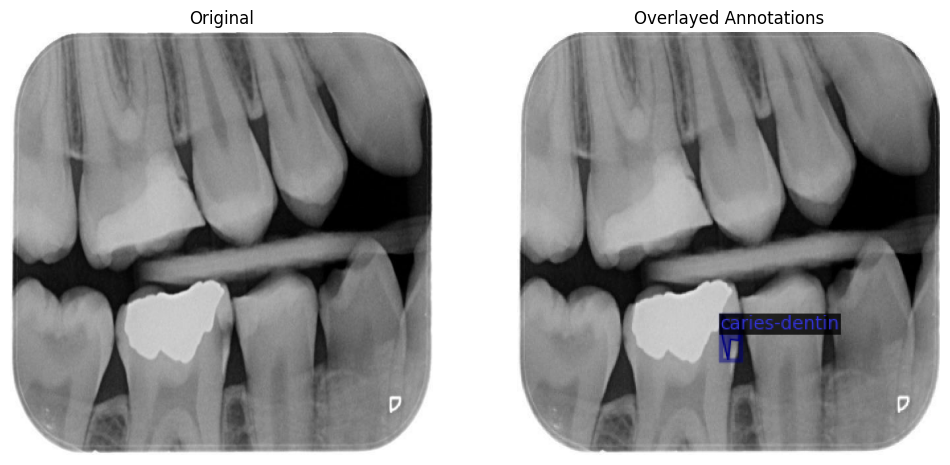

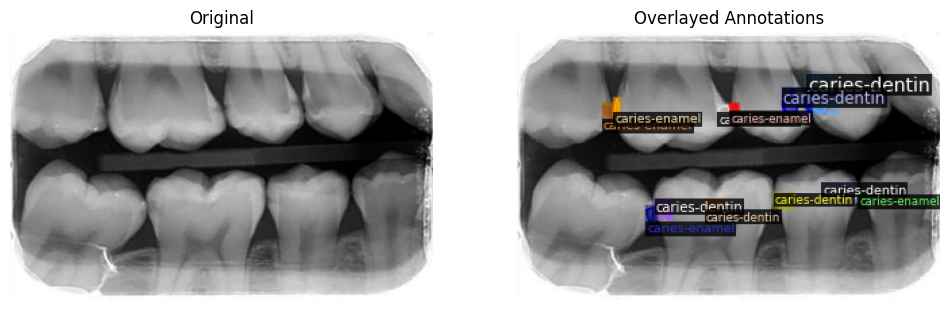

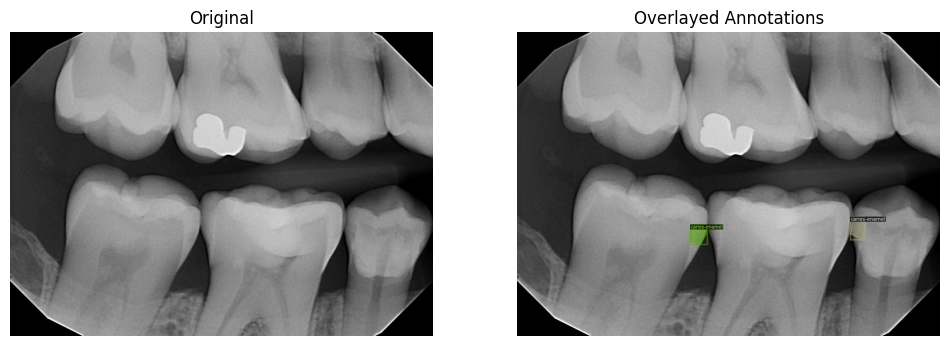

In [ ]:
train_data = DatasetCatalog.get("train")
train_meta = MetadataCatalog.get("train")

for d in random.sample(train_data, 3):
    img = np.array(Image.open(d["file_name"]).convert("RGB"))

    visualizer = Visualizer(img, metadata=train_meta, scale=0.5)
    vis = visualizer.draw_dataset_dict(d).get_image()

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(img)
    ax[0].set_title("Original")
    ax[0].axis("off")

    ax[1].imshow(vis)
    ax[1].set_title("Overlayed Annotations")
    ax[1].axis("off")

    plt.show()

Number of training samples: 1217
Number of validation samples: 347
Number of evaluation samples: 152
Train frequencies:
caries-enamel: 0.43
caries-dentin: 0.50
caries-pulp: 0.07


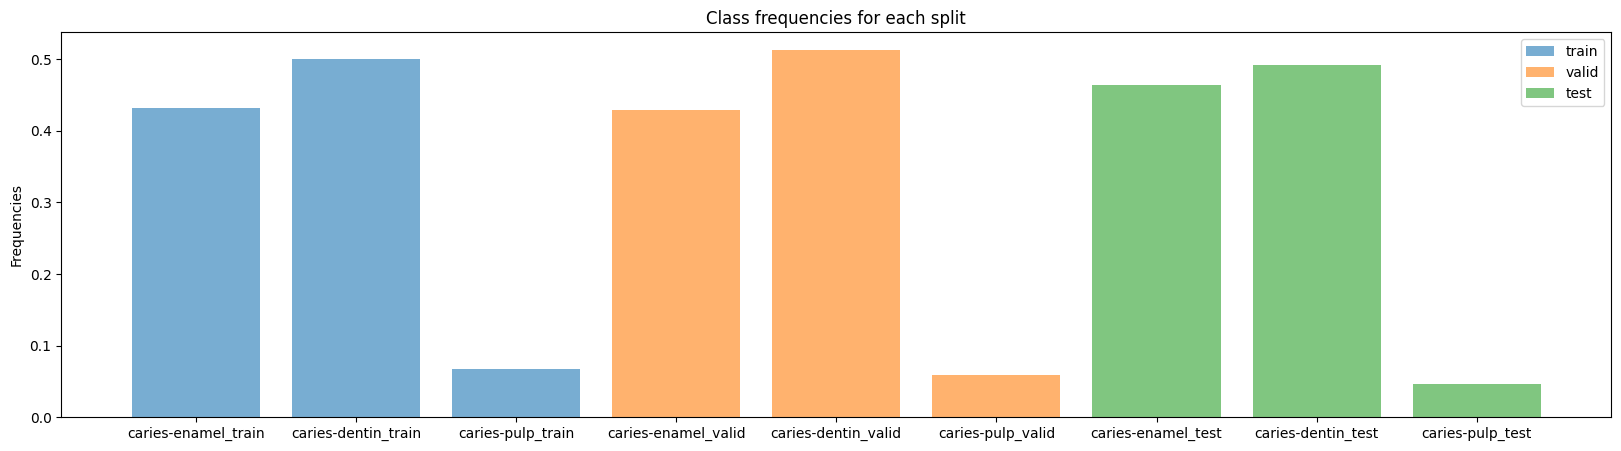

In [ ]:
data_train = DatasetCatalog.get("train")  # training
data_valid = DatasetCatalog.get("valid")  # validation
data_test = DatasetCatalog.get("test")    # evaluation

print(f"Number of training samples: {len(data_train)}")
print(f"Number of validation samples: {len(data_valid)}")
print(f"Number of evaluation samples: {len(data_test)}")

def get_class_frequencies(dataset):
    counts = Counter()
    for item in dataset:
        for ann in item['annotations']:
            counts[ann['category_id']] += 1
    total = sum(counts.values())
    freqs = {k: v/total for k, v in counts.items()}
    return freqs

train_freqs = get_class_frequencies(data_train)
valid_freqs = get_class_frequencies(data_valid)
test_freqs  = get_class_frequencies(data_test)

classes = sorted(train_freqs.keys())
print("Train frequencies:")
for c in classes:
    print(f"{class_names[c]}: {train_freqs[c]:.2f}")

plt.figure(figsize=(20,5))
plt.bar([class_names[c]+'_train' for c in classes], [train_freqs[c] for c in classes], alpha=0.6, label='train')
plt.bar([class_names[c]+'_valid' for c in classes], [valid_freqs[c] for c in classes], alpha=0.6, label='valid')
plt.bar([class_names[c]+'_test' for c in classes], [test_freqs[c] for c in classes], alpha=0.6, label='test')
plt.ylabel("Frequencies")
plt.title("Class frequencies for each split")
plt.legend()
plt.show()

We notice severe class imbalance of `caries-pulp` (7%).

Width bin range: 6.559679999999999
Height bin range: 5.996


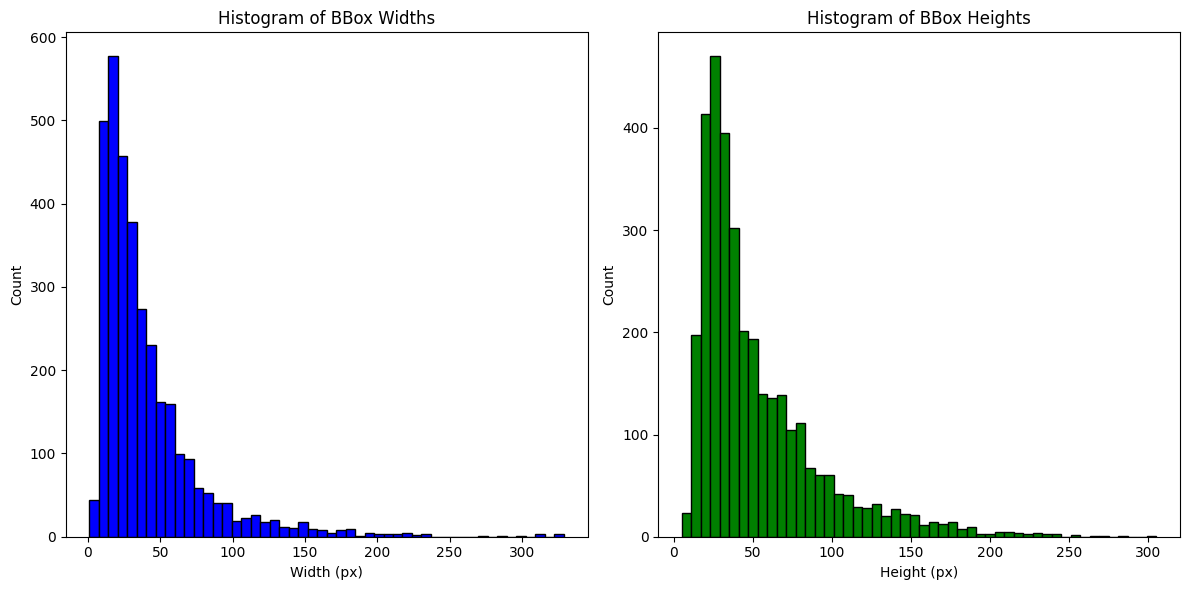

In [ ]:
dataset_dicts = DatasetCatalog.get("train")

widths, heights = [], []
for d in dataset_dicts:
    for ann in d["annotations"]:
        x, y, w, h = ann["bbox"]
        widths.append(w)
        heights.append(h)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=50, color="blue", edgecolor="black")
plt.xlabel("Width (px)")
plt.ylabel("Count")
plt.title("Histogram of BBox Widths")

plt.subplot(1, 2, 2)
num_bins = 50
plt.hist(heights, bins=num_bins, color="green", edgecolor="black")
plt.xlabel("Height (px)")
plt.ylabel("Count")
plt.title("Histogram of BBox Heights")

width_range = (max(widths) - min(widths)) / num_bins
height_range = (max(heights) - min(heights)) / num_bins

print("Width bin range:", width_range)
print("Height bin range:", height_range)

plt.tight_layout()
plt.show()

BBox widths and heights both are right-skewed.

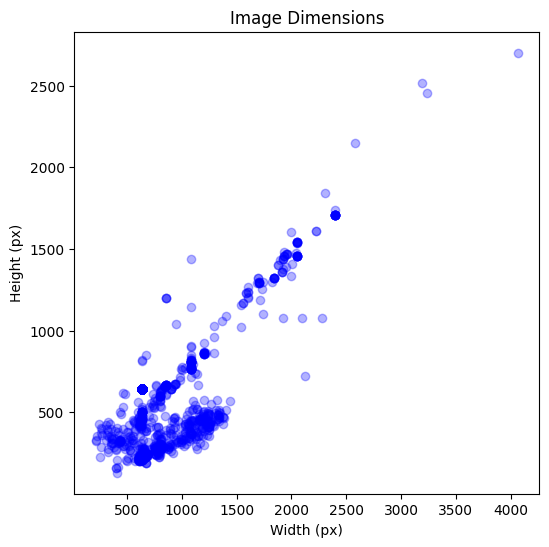

In [ ]:
dataset_dicts = DatasetCatalog.get("train")

plt.figure(figsize=(6, 6))
for image in dataset_dicts:
    width = image["width"]
    height = image["height"]
    plt.plot(width, height, "bo", alpha=0.3)

plt.xlabel("Width (px)")
plt.ylabel("Height (px)")
plt.title("Image Dimensions")
plt.show()

Outliers may negatively influence training.

# Addressing class imbalance

Here we will use per-image oversampling by a factor of 5 for class `caries-pulp`.

In [ ]:
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        data_train = DatasetCatalog.get("train")

        weights = []
        for d in data_train:
            cat_ids = [ann['category_id'] for ann in d['annotations']]
            weights.append(5.0 if 2 in cat_ids else 1.0)  # class index 2 = caries-pulp

        n_samples = cfg.SOLVER.IMS_PER_BATCH * cfg.SOLVER.MAX_ITER * 2  # times 2 for safety
        sampler = WeightedRandomSampler(weights, num_samples=n_samples, replacement=True)

        return build_detection_train_loader(cfg, sampler=sampler)

try:
  trainer = MyTrainer(cfg)
except RuntimeError:
  cfg.MODEL.DEVICE = "cpu"
  trainer = MyTrainer(cfg)

[09/14 03:22:21 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Check new class frequencies:

[09/14 03:22:24 d2.data.datasets.coco]: Loaded 1217 images in COCO format from /content/drive/MyDrive/Colab Notebooks/Dental Caries Lesion Stages/caries-dataset/train/_annotations_clean.coco.json
[09/14 03:22:24 d2.data.datasets.coco]: Loaded 1217 images in COCO format from /content/drive/MyDrive/Colab Notebooks/Dental Caries Lesion Stages/caries-dataset/train/_annotations_clean.coco.json
[09/14 03:22:24 d2.data.build]: Removed 0 images with no usable annotations. 1217 images left.
[09/14 03:22:24 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(1000,), max_size=1500, sample_style='choice'), RandomFlip()]
[09/14 03:22:24 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/14 03:22:24 d2.data.common]: Serializing 1217 elements to byte tensors and concatenating them all ...
[09/14 03:22:24 d2.data.common]: Serialized dataset takes 1.15 MiB
[09/14 03:22:24 d2.data.build]: M

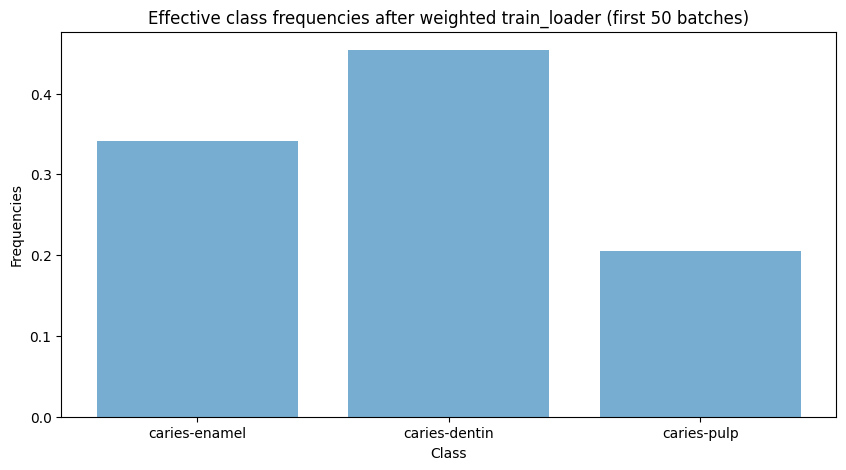

In [ ]:
# count classes in the first N batches
counter = Counter()
N_batches = 50
for i, batch in enumerate(trainer.build_train_loader(cfg)):
    for sample in batch:
        anns = sample["instances"].gt_classes
        counter.update(anns.tolist())
    if i >= N_batches - 1:
        break

total = sum(counter.values())
classes = sorted(counter.keys())
frequencies = [counter[c]/total for c in classes]
print("Train frequencies:")
for c in classes:
    print(f"{class_names[c]}: {frequencies[c]:.2f}")

plt.figure(figsize=(10,5))
plt.bar([class_names[c] for c in classes], frequencies, alpha=0.6)
plt.ylabel("Frequencies")
plt.xlabel("Class")
plt.title(f"Effective class frequencies after weighted train_loader (first {N_batches} batches)")
plt.show()


After balancing, previously severely underrepresented class `caries-pulp` is resampled from around 7% to around 20%.

# Train

In [ ]:
cfg.DATASETS.TEST = ("valid",)
trainer.resume_or_load(resume=False)
trainer.train()

[09/14 03:22:41 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:00, 224MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[09/14 03:22:42 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[09/14 03:23:12 d2.utils.events]:  eta: 1:07:55  iter: 19  total_loss: 2.9  loss_cls: 1.454  loss_box_reg: 0.09454  loss_mask: 0.6946  loss_rpn_cls: 0.5962  loss_rpn_loc: 0.03569    time: 1.2365  last_time: 1.0136  data_time: 0.0588  last_data_time: 0.0236   lr: 4.9953e-06  max_mem: 6828M
[09/14 03:23:43 d2.utils.events]:  eta: 1:08:40  iter: 39  total_loss: 2.626  loss_cls: 1.291  loss_box_reg: 0.1311  loss_mask: 0.6942  loss_rpn_cls: 0.4599  loss_rpn_loc: 0.04048    time: 1.2873  last_time: 1.4231  data_time: 0.0189  last_data_time: 0.0100   lr: 9.9902e-06  max_mem: 6828M
[09/14 03:24:08 d2.utils.events]:  eta: 1:07:50  iter: 59  total_loss: 2.176  loss_cls: 0.9832  loss_box_reg: 0.09481  loss_mask: 0.6928  loss_rpn_cls: 0.4067  loss_rpn_loc: 0.02869    time: 1.2791  last_time: 1.0458  data_time: 0.0164  last_data_time: 0.0086   lr: 1.4985e-05  max_mem: 6828M
[09/14 03:24:35 d2.utils.events]:  eta: 1:08:09  iter: 79  total_loss: 1.862  loss_cls: 0.6903  loss_box_reg: 0.1582  loss_mas

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[09/14 03:34:36 d2.utils.events]:  eta: 1:01:07  iter: 519  total_loss: 1.577  loss_cls: 0.4514  loss_box_reg: 0.5349  loss_mask: 0.5039  loss_rpn_cls: 0.03053  loss_rpn_loc: 0.01472    time: 1.3543  last_time: 1.5412  data_time: 0.0257  last_data_time: 0.0124   lr: 0.00012987  max_mem: 6831M
[09/14 03:35:02 d2.utils.events]:  eta: 1:00:36  iter: 539  total_loss: 1.58  loss_cls: 0.4536  loss_box_reg: 0.5574  loss_mask: 0.501  loss_rpn_cls: 0.05157  loss_rpn_loc: 0.01508    time: 1.3536  last_time: 1.5519  data_time: 0.0313  last_data_time: 0.0092   lr: 0.00013487  max_mem: 6831M
[09/14 03:35:28 d2.utils.events]:  eta: 0:59:51  iter: 559  total_loss: 1.53  loss_cls: 0.424  loss_box_reg: 0.5415  loss_mask: 0.4655  loss_rpn_cls: 0.03593  loss_rpn_loc: 0.01633    time: 1.3511  last_time: 1.5399  data_time: 0.0266  last_data_time: 0.0173   lr: 0.00013986  max_mem: 6831M
[09/14 03:35:56 d2.utils.events]:  eta: 0:59:35  iter: 579  total_loss: 1.611  loss_cls: 0.4289  loss_box_reg: 0.6077  los

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[09/14 03:46:01 d2.utils.events]:  eta: 0:50:02  iter: 1019  total_loss: 1.305  loss_cls: 0.3615  loss_box_reg: 0.5265  loss_mask: 0.3417  loss_rpn_cls: 0.01637  loss_rpn_loc: 0.01302    time: 1.3618  last_time: 1.3693  data_time: 0.0276  last_data_time: 0.0350   lr: 0.00025  max_mem: 6831M
[09/14 03:46:30 d2.utils.events]:  eta: 0:49:46  iter: 1039  total_loss: 1.163  loss_cls: 0.3246  loss_box_reg: 0.4833  loss_mask: 0.3551  loss_rpn_cls: 0.02118  loss_rpn_loc: 0.01242    time: 1.3635  last_time: 1.5647  data_time: 0.0240  last_data_time: 0.0193   lr: 0.00025  max_mem: 6831M
[09/14 03:46:57 d2.utils.events]:  eta: 0:49:27  iter: 1059  total_loss: 1.228  loss_cls: 0.3081  loss_box_reg: 0.5078  loss_mask: 0.3716  loss_rpn_cls: 0.01562  loss_rpn_loc: 0.01636    time: 1.3639  last_time: 1.6109  data_time: 0.0329  last_data_time: 0.0412   lr: 0.00025  max_mem: 6831M
[09/14 03:47:26 d2.utils.events]:  eta: 0:48:59  iter: 1079  total_loss: 1.057  loss_cls: 0.2685  loss_box_reg: 0.4764  loss

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[09/14 03:57:39 d2.utils.events]:  eta: 0:38:10  iter: 1519  total_loss: 1.024  loss_cls: 0.2496  loss_box_reg: 0.4543  loss_mask: 0.3057  loss_rpn_cls: 0.01014  loss_rpn_loc: 0.01305    time: 1.3728  last_time: 1.6059  data_time: 0.0281  last_data_time: 0.0358   lr: 0.00025  max_mem: 6831M
[09/14 03:58:07 d2.utils.events]:  eta: 0:37:41  iter: 1539  total_loss: 1.023  loss_cls: 0.2572  loss_box_reg: 0.4571  loss_mask: 0.3319  loss_rpn_cls: 0.01048  loss_rpn_loc: 0.01118    time: 1.3731  last_time: 0.9773  data_time: 0.0299  last_data_time: 0.0115   lr: 0.00025  max_mem: 6831M
[09/14 03:58:33 d2.utils.events]:  eta: 0:37:12  iter: 1559  total_loss: 1.108  loss_cls: 0.2823  loss_box_reg: 0.4876  loss_mask: 0.3123  loss_rpn_cls: 0.01135  loss_rpn_loc: 0.01262    time: 1.3727  last_time: 0.9697  data_time: 0.0248  last_data_time: 0.0096   lr: 0.00025  max_mem: 6831M
[09/14 03:59:01 d2.utils.events]:  eta: 0:36:42  iter: 1579  total_loss: 1.092  loss_cls: 0.2547  loss_box_reg: 0.4643  loss

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[09/14 04:09:18 d2.utils.events]:  eta: 0:25:28  iter: 2019  total_loss: 0.9676  loss_cls: 0.2257  loss_box_reg: 0.398  loss_mask: 0.2949  loss_rpn_cls: 0.006685  loss_rpn_loc: 0.01362    time: 1.3793  last_time: 1.3347  data_time: 0.0288  last_data_time: 0.0106   lr: 0.000125  max_mem: 6831M
[09/14 04:09:47 d2.utils.events]:  eta: 0:24:57  iter: 2039  total_loss: 0.9187  loss_cls: 0.2195  loss_box_reg: 0.3938  loss_mask: 0.2847  loss_rpn_cls: 0.008117  loss_rpn_loc: 0.01072    time: 1.3798  last_time: 1.1109  data_time: 0.0302  last_data_time: 0.0109   lr: 0.000125  max_mem: 6831M
[09/14 04:10:15 d2.utils.events]:  eta: 0:24:25  iter: 2059  total_loss: 0.9016  loss_cls: 0.2123  loss_box_reg: 0.3963  loss_mask: 0.2724  loss_rpn_cls: 0.007687  loss_rpn_loc: 0.009827    time: 1.3798  last_time: 1.4421  data_time: 0.0336  last_data_time: 0.0525   lr: 0.000125  max_mem: 6831M
[09/14 04:10:41 d2.utils.events]:  eta: 0:23:54  iter: 2079  total_loss: 0.9521  loss_cls: 0.2499  loss_box_reg: 0.

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[09/14 04:21:04 d2.utils.events]:  eta: 0:12:30  iter: 2519  total_loss: 0.9826  loss_cls: 0.2369  loss_box_reg: 0.3845  loss_mask: 0.2994  loss_rpn_cls: 0.009736  loss_rpn_loc: 0.0121    time: 1.3854  last_time: 1.1526  data_time: 0.0308  last_data_time: 0.0341   lr: 6.25e-05  max_mem: 6831M
[09/14 04:21:30 d2.utils.events]:  eta: 0:11:58  iter: 2539  total_loss: 0.8742  loss_cls: 0.1943  loss_box_reg: 0.3783  loss_mask: 0.2743  loss_rpn_cls: 0.006257  loss_rpn_loc: 0.009932    time: 1.3850  last_time: 1.5997  data_time: 0.0291  last_data_time: 0.0370   lr: 6.25e-05  max_mem: 6831M
[09/14 04:21:59 d2.utils.events]:  eta: 0:11:27  iter: 2559  total_loss: 0.8556  loss_cls: 0.2123  loss_box_reg: 0.3624  loss_mask: 0.2532  loss_rpn_cls: 0.007791  loss_rpn_loc: 0.007863    time: 1.3855  last_time: 1.5975  data_time: 0.0225  last_data_time: 0.0099   lr: 6.25e-05  max_mem: 6831M
[09/14 04:22:28 d2.utils.events]:  eta: 0:10:56  iter: 2579  total_loss: 0.801  loss_cls: 0.1653  loss_box_reg: 0.

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Evaluation

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

In [ ]:
cfg.DATASETS.TEST = ("test",)
evaluator = COCOEvaluator("test", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "test")
metrics = inference_on_dataset(trainer.model, val_loader, evaluator)

metrics

WARNING [09/14 04:32:19 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/14 04:32:19 d2.data.datasets.coco]: Loaded 152 images in COCO format from /content/drive/MyDrive/Colab Notebooks/Dental Caries Lesion Stages/caries-dataset/test/_annotations_clean.coco.json
[09/14 04:32:19 d2.data.build]: Distribution of instances among all 3 categories:
|   category    | #instances   |   category    | #instances   |  category   | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-----------:|:-------------|
| caries-enamel | 182          | caries-dentin | 193          | caries-pulp | 18           |
|               |              |               |              |             |              |
|     total     | 393          |               |              |             |              |
[09/14 04:32:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference:

OrderedDict([('bbox',
              {'AP': 19.038690253113124,
               'AP50': 45.80654046354031,
               'AP75': 12.364047104540365,
               'APs': 14.828087593526245,
               'APm': 21.82817017150985,
               'APl': 19.245824334690806,
               'AP-caries-enamel': 14.86898007648395,
               'AP-caries-dentin': 23.612082372186237,
               'AP-caries-pulp': 18.635008310669186}),
             ('segm',
              {'AP': 18.601512526664152,
               'AP50': 43.409416951397276,
               'AP75': 11.700955503545739,
               'APs': 11.28359275396783,
               'APm': 17.78632881023635,
               'APl': 30.174900834431277,
               'AP-caries-enamel': 13.482981338224848,
               'AP-caries-dentin': 20.384797918251493,
               'AP-caries-pulp': 21.936758323516102})])

Plot some graphs

dict_keys(['rpn/num_pos_anchors', 'rpn/num_neg_anchors', 'roi_head/num_fg_samples', 'roi_head/num_bg_samples', 'fast_rcnn/cls_accuracy', 'fast_rcnn/fg_cls_accuracy', 'fast_rcnn/false_negative', 'mask_rcnn/accuracy', 'mask_rcnn/false_positive', 'mask_rcnn/false_negative', 'rank_data_time', 'data_time', 'total_loss', 'loss_cls', 'loss_box_reg', 'loss_mask', 'loss_rpn_cls', 'loss_rpn_loc', 'lr', 'time', 'eta_seconds'])


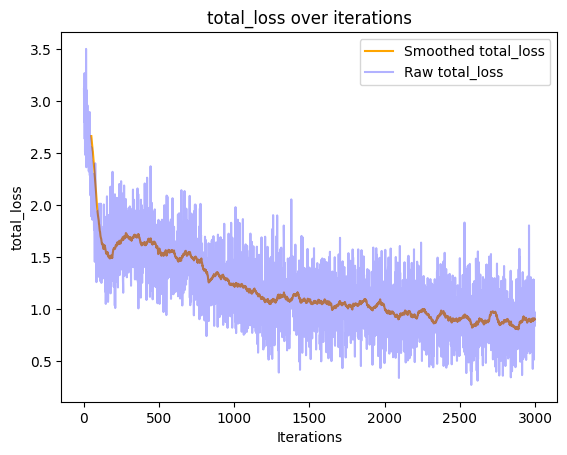

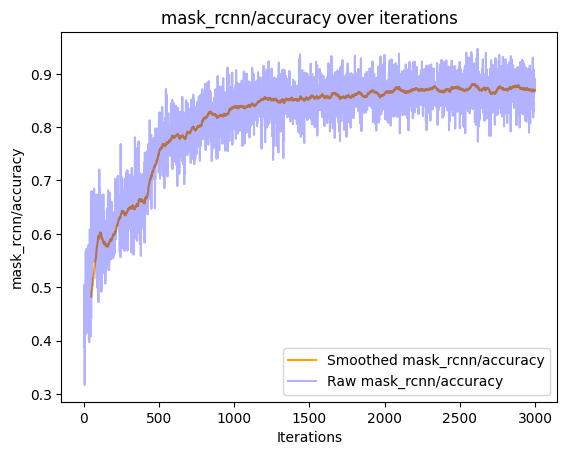

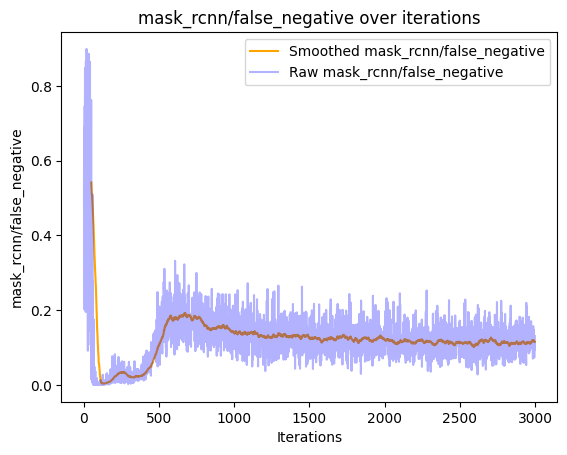

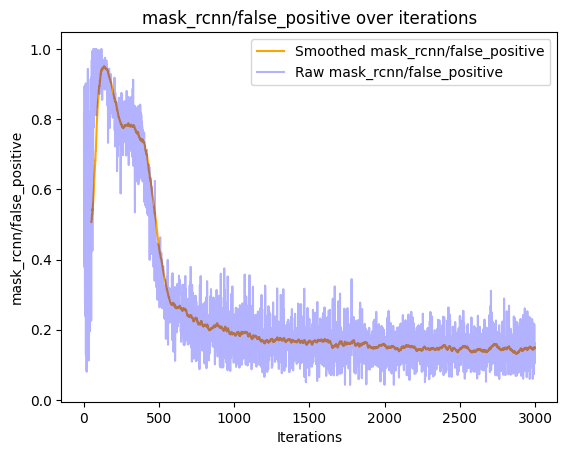

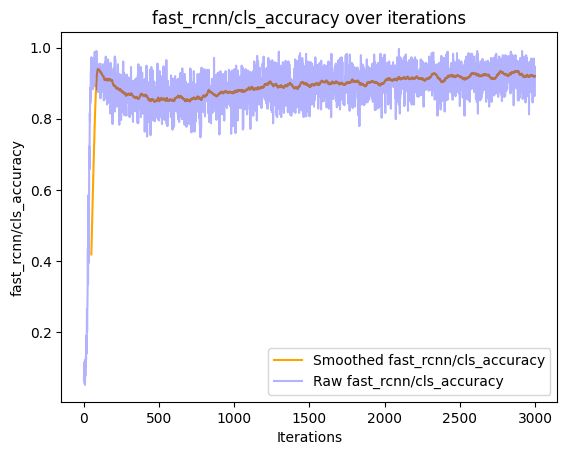

In [ ]:
def plot_metric(metric_name):
    metrics = []
    iters = []

    for event in trainer.storage.history(metric_name).values():
        iters.append(event[1])
        metrics.append(event[0])

    window = 50
    smooth_metric = np.convolve(metrics, np.ones(window)/window, mode='valid')

    plt.plot(iters[window-1:], smooth_metric, label=f"Smoothed {metric_name}", color="orange")
    plt.plot(iters, metrics, alpha=0.3, label=f"Raw {metric_name}", color="blue")
    plt.xlabel("Iterations")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} over iterations")
    plt.legend()
    plt.show()

print(trainer.storage.histories().keys())

plot_metric("total_loss")
plot_metric("mask_rcnn/accuracy")
plot_metric("mask_rcnn/false_negative")
plot_metric("mask_rcnn/false_positive")
plot_metric("fast_rcnn/cls_accuracy")

Visualize model inference

[09/14 05:19:36 d2.data.datasets.coco]: Loaded 152 images in COCO format from /content/drive/MyDrive/Colab Notebooks/Dental Caries Lesion Stages/caries-dataset/test/_annotations_clean.coco.json


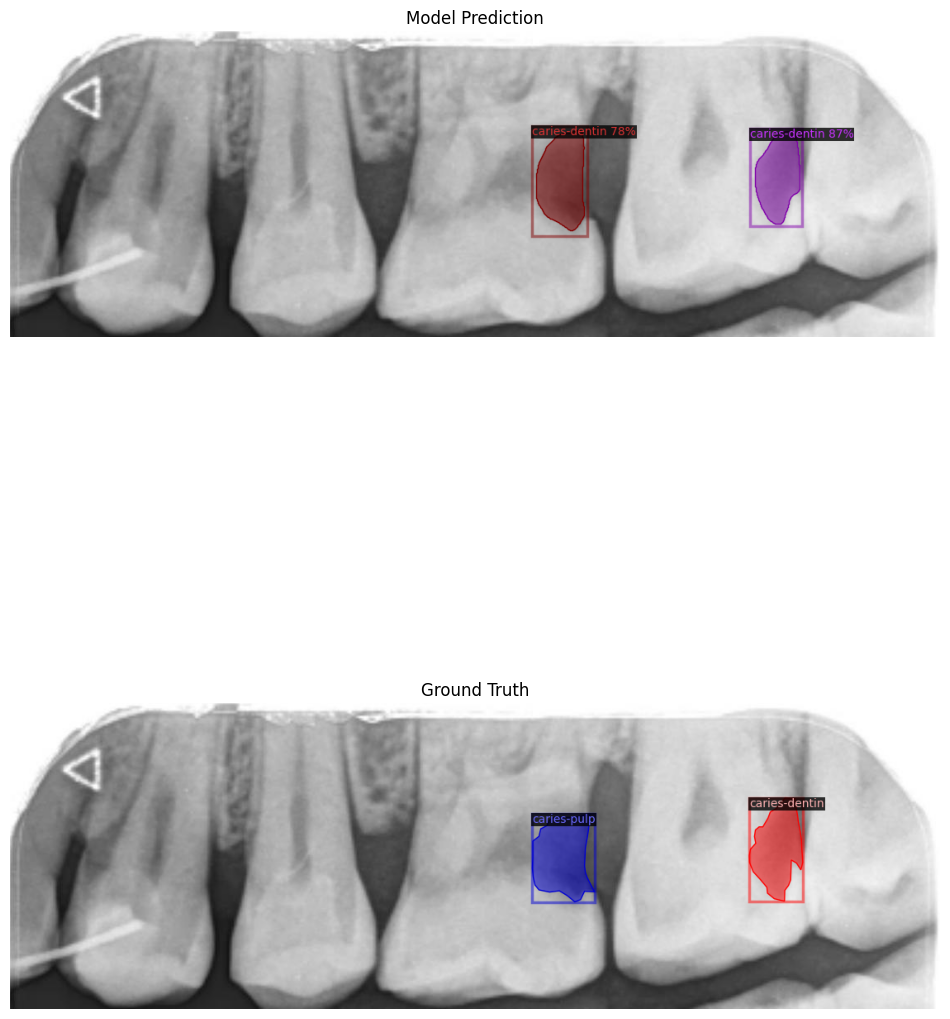

In [54]:
model = trainer.model
model.eval()

test_data = DatasetCatalog.get("test")
test_meta = MetadataCatalog.get("test")
img_dict = random.choice(test_data)
img = cv2.imread(img_dict["file_name"])

with torch.no_grad():
    outputs = model([{"image": torch.as_tensor(img.transpose(2, 0, 1))}])

v_pred = Visualizer(img[:, :, ::-1], metadata=test_meta, scale=1.0)
instances = outputs[0]["instances"]
instances = instances[instances.scores > 0.5]
out_pred = v_pred.draw_instance_predictions(instances.to("cpu"))
pred_img = out_pred.get_image()[:, :, ::-1]

v_gt = Visualizer(img[:, :, ::-1], metadata=test_meta, scale=1.0)
out_gt = v_gt.draw_dataset_dict(img_dict)
gt_img = out_gt.get_image()[:, :, ::-1]

plt.figure(figsize=(12, 16))
plt.subplot(2, 1, 1)
plt.imshow(pred_img)
plt.title("Model Prediction")
plt.axis("off")
plt.subplot(2, 1, 2)
plt.imshow(gt_img)
plt.title("Ground Truth")
plt.axis("off")
plt.show()